# Content-Based Image Retrieval
In this notebook we are going to implement a simple Content-Based image retrieval system. It takes in input an image and returns the *k-nearest-neighbours* images in the dataset. In order to build a CBIR system, there are four important steps to take:

1. __Define an image descriptor__: decide which aspect of the image you want to describe.

2. __Index the dataset__: apply the descriptor to each image in your dataset and store the extracted feature vectors.

3. __Define a similarity metric__: choose how to compare the images. This is highly dependent on the type of pictures and features that you have.

4. __Searching__: perform the actual search.

In [1]:
import os
import cv2
import csv
import time
import glob
import utils
import pandas
import numpy as np
import matplotlib.pyplot as plt

## Dataset of images

Before starting with the actual system, we have to download a dataset of images. We decide to work on the CIFAR-10 dataset, that consists of 60000 32x32 colour images divided in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The detailed description can be found here: https://www.cs.toronto.edu/~kriz/cifar.html.

In [2]:
%%capture
%%bash
# script to download the CIFAR-10 dataset
FILE=cifar-10-python.tar.gz
if test ! -f "$FILE"; then
    wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
    tar -xvzf cifar-10-python.tar.gz
fi

In the *utils.py* file we have implemented the *load_dataset()* method that helps us to load the images in a proper way. 

In the output below, we can observe how the dataset looks like.

The dataset:
Images:  (50000, 32, 32, 3)
Queries:  (10, 32, 32, 3)

The 10 classes of objects are: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Random images in a 4x4 grid:


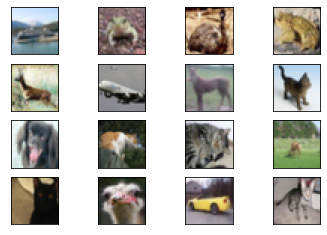

In [3]:
num_images = 50000
num_queries = 10

images, images_filenames, images_labels, \
queries, queries_filenames, queries_labels, label_names = utils.load_dataset(train=num_images, test=num_queries)
dataset = images, images_filenames, images_labels, queries, queries_filenames, queries_labels, label_names 

print('The dataset:')
print('Images: ', np.shape(images))
print('Queries: ', np.shape(queries))
print('\nThe 10 classes of objects are:', label_names)

print('\nRandom images in a 4x4 grid:')
num_plot = 4
f, ax = plt.subplots(num_plot, num_plot)
for m in range(num_plot):
    for n in range(num_plot):
        idx = np.random.randint(0, images.shape[0])
        ax[m, n].imshow(images[idx])
        ax[m, n].get_xaxis().set_visible(False)
        ax[m, n].get_yaxis().set_visible(False)
plt.show()

## Step 1: Image descriptor

In this section, we are going to define the class *ImageDescriptor*, which implements the algorithm used to describe an image. The output of this object is a vector of features (as it is shown in the picture below).

<img src="support_images/describing_images.jpg" width="500px" align="center" />

Now, the first important point is to choose which features to extract. We decide to use a simple one: __the colour histogram__; therefore we rely on the *colour distribution* of the image. Obviously, this brings with it an important assumption regarding our system: images that have similar colour distributions will be considered relevant to each other, even though they have dramatically different contents.

In addition, we are going to apply a few tricks to make the descriptor a little more robust and powerful.

### Colour space

We want to try two different colour spaces: the __RGB__ (Red, Green, Blue) and the __HSV__ (Hue, Saturation, Value) representations. This allow us to compare RGB values, that are quite simple to understand but fails to mimic how humans perceive colours, against the HSV color space which is more complex but a bit more perceptually uniform. There are other colour spaces that we could take into consideration, but let’s keep our model relatively simple.

### Number of bins

Now that we have selected a colour space, we need to define the number of bins for our histogram. If you select too few bins, then the histogram will have less components and it will be unable to distinguish between images with substantially different colour distributions. Likewise, if you use too many bins, images with very similar contents may be regarded “not similar” when in reality they are. 

In general, the choice depends on the size of the dataset and on how similar the color distributions in your dataset are to each other. In our example, we are choosing 8 bins for each RGB channel and 8, 12 and 3 bins respectively for the HSV channels.

### Help the localization

The simplest idea is to compute a __global__ histogram for the entire image, but this would not be able to represent in some way where the colours are in the picture. In addition, many images could share very similar distributions because of the background. To avoid the latter problem, one could compute __focal__ histograms taking into cosideration only part of the image. For the problem of locality instead, one could use __central__ histograms, by dividing the image into five regions and giving different weights to them. 

However, for the sake of simplicity, let's compare only the first two solutions. In particular, considered our dataset, we will examine only the central 25% pixels of the pictures.

Here we have the final implementation:

In [4]:
class ImageDescriptor:
    
    def __init__(self, bins, hsv=False, focal=False):
        self.bins = bins     # storing number of bins for histogram
        self.hsv = hsv       # RGB or HSV histograms
        self.focal = focal   # Global or Focal histograms
        
    def extract_features(self, image):
        '''
        input: an image
        output: a list representing a colour histogram
        '''
        image = image.astype('uint8')
        center_mask = None
        ranges = [0, 256, 0, 256, 0, 256]
        
        if self.hsv == True:       
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) # convert the image into hsv
            ranges = [0, 180, 0, 256, 0, 256]              # hsv uses different ranges
        
        if self.focal == True:  # extract the histogram only for the central part
            
            (h, w) = image.shape[:2]  # dim of the image              
            (axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
            center_mask = np.zeros(image.shape[:2], dtype = "uint8")
            start_point = (axesX, axesY)
            end_point = (w-axesX, h-axesY)
            cv2.rectangle(center_mask, start_point, end_point, color=255 , thickness=-1)
            
        hist = cv2.calcHist([image], channels=[0, 1, 2], mask=center_mask, \
                            histSize=self.bins, ranges=ranges) 
        
        # normalize the histogram
        hist = cv2.normalize(hist, hist).flatten()
        
        return hist

##  Step 2: Index the dataset
Here we simply apply the descriptor to each image and store the features into a *.csv* file.

We will have different indexes, one for each group of parameters that we will choose for the image descriptor.

In [5]:
def index_images(images, parameters):
    '''
    input: the images and the set of parameters 
    output: None
    The procedure indexes the dataset according to the given parameters
    '''
    for name,par in parameters.items():
        
        # check if the index is already present
        if os.path.isfile('indexes/index_'+ name +'.csv'):
            file = pandas.read_csv('indexes/index_'+ name +'.csv', header=None)
            
            if file.shape[0] == num_images:
                print('index_'+ name +' already present')
                continue
        
        print('Building index_' + name +'...')
        cd = ImageDescriptor(bins=par[0], hsv=par[1], focal=par[2])
        
        with open('indexes/index_'+ name +'.csv','w') as index:

            for idx, image in enumerate(images):
                features = cd.extract_features(image)
                features = [str(f) for f in features]
                index.write('%s,%s\n' % (idx, ','.join(features)))   

In [6]:
# different parameters for the ImageDescriptor
all_parameters = {'rgb_global':[(8,8,8), False, False],
                  'rgb_focal':[(8,8,8), False, True],
                  'hsv_global':[(8,12,3), True, False],
                  'hsv_focal':[(8,12,3), True, True]}

# set the parameters -> comment the methods that you do not want to compute
methods = [] 
methods.append('rgb_global')
methods.append('rgb_focal')
methods.append('hsv_global')
methods.append('hsv_focal')
parameters = dict([pars for pars in all_parameters.items() if pars[0] in methods])

# index the images
start_time = time.time()
index_images(images, parameters)
end_time = time.time()
print('Indexing the dataset took:', round(end_time - start_time, 2), 'seconds for', len(methods), 'methods')

Building index_rgb_global...
Building index_rgb_focal...
Building index_hsv_global...
Building index_hsv_focal...
Indexing the dataset took: 37.36 seconds for 4 methods


Let's show the sizes of the features vectors with every method used.

They depend on the *bin_size* parameter that we chose and whether we used *global* or *focal* histograms.

In [7]:
print('Size of features vectors:\n')
for name in parameters.keys():
    result = pandas.read_csv('indexes/index_'+name+'.csv', header=None)
    print(name,'\t', np.shape(result))

Size of features vectors:

rgb_global 	 (50000, 513)
rgb_focal 	 (50000, 513)
hsv_global 	 (50000, 289)
hsv_focal 	 (50000, 289)


##  Step 3: Define a similarity metric
Since we are comparing colour histograms, which are by definition probability distributions, the $\chi^2$ function is an excellent choice of similarity metric. It derives from the statistical field where it is used to measure how different two frequency distributions are, and it is defined as:

$$
    \begin{align*}
        d_{\chi^2}(v,w) = \sum_i \frac{(v_i - m_i)^2}{m_i}
    \end{align*}
$$

where $m=\frac{(v+w)}{2}$.

Images that have $d_{\chi^2}(v,w)=0$ will be deemed identical. As the value increases, the images are considered to be less similar to each other.


##   Step 4: Searching


Now that we have extracted features from our dataset, we need a method that compares them. The class *Searcher* has exactly this goal: it takes in input the index and the features of the image query and defines the actual similarity metric between each indexed item and the query. It will return an ordered list of images and distances.

In [8]:
class Searcher:
    
    def __init__(self, index_path):
        self.index_path = index_path
        
    def search(self, query_features):
        '''
        input: the query features
        output: a list of images and their distance from the query
        '''
        results = dict()
        with open(self.index_path) as index:
          
            reader = csv.reader(index)
            
            # loop over the images in the index
            for image in reader:
                
                features = [float(x) for x in image[1:]]
                
                d = self.chi2_distance(features, query_features) # dissimilarity measure
                
                results[image[0]] = [d]
           
            index.close()

        # rank the results
        results = sorted([(d,image) for (image,d) in results.items()])
        
        results = [[ i for i, j in results ], [ j for i, j in results ]] 
  
        return results
    
    def chi2_distance(self, histA, histB, eps = 1e-10):
        
        d = 0.5 * np.sum([((v-w) ** 2) / (v + w + eps) for (v, w) in zip(histA, histB)])
        
        return d

The actual search is performed by the procedure *search_image()*, that extracts the features from the query image and retrieves the results.

In [9]:
def search_images(image_query, parameters):
    '''
    input: the image query and the set of parameters 
    output: an ordered dictionary of images and distances
    '''
    results = dict()
    for t,par in parameters.items():
        print('Searching index_' + t +'...')
        cd = ImageDescriptor(bins=par[0], hsv=par[1], focal=par[2])
        query_features = cd.extract_features(image_query[0])      
        s = Searcher('indexes/index_'+t+'.csv')

        results[t] = s.search(query_features)
        
    return results

In [10]:
# set the query image
idx_query = 0
image_query = [queries[idx_query], queries_filenames[idx_query], queries_labels[idx_query]]

# actual search
start_time = time.time()
results = search_images(image_query, parameters)
end_time = time.time()
print('The query search took:', round(end_time - start_time, 2), 'seconds for', len(methods), 'methods')

The query search took: 383.23 seconds for 4 methods


# Plot the results
With this procedure we can plot the *k-nearest-neighbours* retrieved by our system, with the different set of parameters and with an indication of each image label.

Query image domestic_cat_s_000907.png
Class: cat


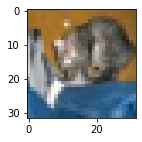


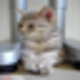
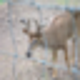
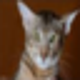
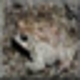
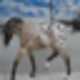
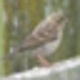
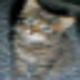
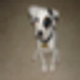
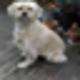
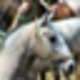
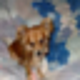
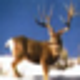
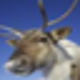
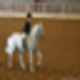
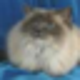
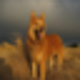
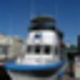
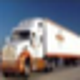
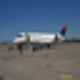
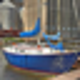
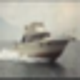
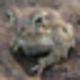
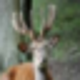
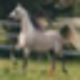
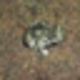
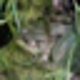
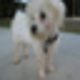
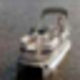
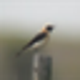
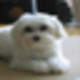
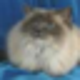
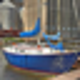
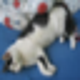
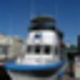
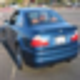
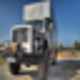
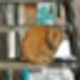
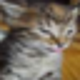
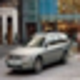
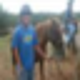


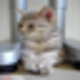
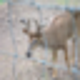
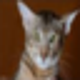
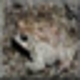
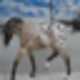
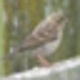
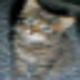
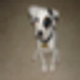
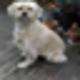
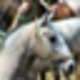
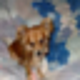
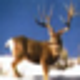
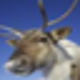
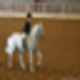
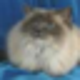
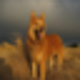
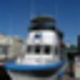
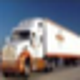
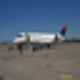
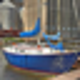
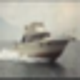
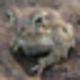
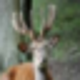
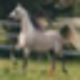
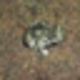
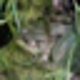
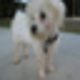
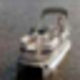
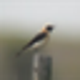
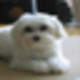
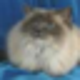
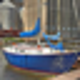
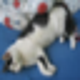
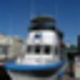
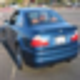
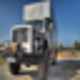
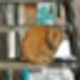
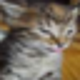
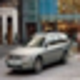
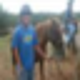

In [11]:
K = 10
utils.plot_results(image_query, results, k=K, labels=list(parameters.keys()), dataset=dataset)

## Evaluate the system
Finally, we are going to evaluate our system for each set of parameters, in order to discover which is the best one. For this purpose, we will use the class label that every image in the CIFAR-10 dataset has. A retrieved picture is considered *relevant* by our system if it has the same label as the image query. Of course, this is our way of seeing the meaning of the word "*relevant*", but it could be enough to have a crude evaluation of a simple system.

Both metrics that we are going to use allow us to have a single evaluation number for each query image and then to average between many queries.

The first is the __Mean Average Precision@K__ defined as:
$$
    \begin{align*}
        MAP@K(Q) = \frac{1}{n} \sum_{j=1}^n \Big( \frac{1}{K} \sum_{k=1}^K P@k(q_j) \Big)
    \end{align*}
$$
    
where $Q=\{q_1,\dots,q_n\}$ is a set of $n$ queries, $K$ is the number of retrieved images and P@k is the __Precision@K__ and it is defined as:

$$
    \begin{align*}
        P@K(q) = \frac{\text{# relevant images of the top $K$}}{\text{$K$}}
    \end{align*}
$$

The second one is the __Mean R-Precision__ and it is defined as:

$$
    \begin{align*}
        MRP(Q) = \frac{1}{n} \sum_{j=1}^n \frac{\text{# relevant images of the top $TR$}}{\text{$TR$}}
    \end{align*}
$$

where $TR$ is the number of relevant images in the whole dataset for a specific query $q_j$.

In [12]:
def evaluate(queries, K, method):
    
    total_prec_at_k = 0
    total_r_prec = 0
    
    for idx, image in enumerate(queries):
        image_query = [image, queries_filenames[idx], queries_labels[idx]]
       
        parameters = dict([pars for pars in all_parameters.items() if pars[0]==method])

        results = search_images(image_query, parameters)
        results = [r[1] for r in results.values()] 
        results = [img for l in results for img in l]
        classes = [label_names[images_labels[int(idx)]] for idx in results]
        
        # compute the r_precision 
        relevant_images = classes.count(label_names[image_query[2]])
        relevant_results = classes[:relevant_images].count(label_names[image_query[2]])                        
        total_r_prec += relevant_results / relevant_images
        
        # compute the AP@K
        prec_at_k = 0
        
        for k in range(1, K+1):
            relevant = classes[:k].count(label_names[image_query[2]])
            prec_at_k += relevant/k
     
        avg_prec_at_k = prec_at_k / K # avg on all values of k                
        
        total_prec_at_k += avg_prec_at_k 
    
    # compute the mean of the two metrics over all queries 
    mean_avg_prec_at_k = total_prec_at_k / len(queries) 
    mean_r_prec = total_r_prec / len(queries)
    
    return mean_avg_prec_at_k, mean_r_prec

In [13]:
K = 10
start_time = time.time()
print('\t\t MAP@K \t\t r_precision\n')
for par in parameters.keys():
    MAP_at_K, mean_r_prec = evaluate(queries, K, method=par)
    print(par, '\t', round(MAP_at_K*100, 2), '% \t', round(mean_r_prec*100, 2), '%')
end_time = time.time()

print('\nThe evaluation phase took:', round(end_time - start_time, 2), 'seconds')
print('\nDataset:', num_images, 'images')
print('\nQueries', num_queries, 'images')

		 MAP@K 		 r_precision

rgb_global 	 35.69 % 	 20.06 %
rgb_focal 	 33.45 % 	 19.72 %
hsv_global 	 37.49 % 	 21.17 %
hsv_focal 	 40.33 % 	 21.73 %

The evaluation phase took: 3773.68 seconds

Dataset: 50000 images

Queries 10 images


From the results above, we can observe that our CBIR system works better with an image descriptor that creates colour histograms using the HSV colour space and taking into consideration only the central 25% pixels of an image. In any case, these are pretty good numbers for a simple system like this one.

## What comes next
This last part is dedicated to some improvements that one could adopt. In particular, the colour histogram could be enhanced by:
- using a more complicated colour space;
- tuning the number of bins experimentally;
- taking into account many areas of the image, giving them different weights.

Other possibilities could be to choose a different type of feature to describe the image, or to compute the similarity with another measure. Even better, one could use many features in order to capture different aspect of a picture.

Regarding the evaluation phase, an option could be to implement an algorithm of *relevance feedback* involving the final user, instead of using the class labels present in the CIFAR-10.

### Responsivness problem

The really big problem with this CBIR system is that it is really slow. The bigger is the dataset of images, the longer is the response time for one single query. Now, with 50000 pictures, we have to wait at least 30 seconds and this is not acceptable in a real-world system. This is because we are comparing each image with the query and this is both time-consuming and useless. 

Multiple approaches are available to avoid too many comparisons:
- __Fingerprints__: computed through a *Locality Sensitive Hashing* algorithm, that allows us to map each image from the feature space to an hash table and therefore to compare the query only with images that have the same hash code
- __Automatic image annotation__ techniques: performed before to concentrate the search only to a subset of the images
- __Cluster Pruning__ approaches